In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
from tqdm import tqdm

def create_grid(positions, r):
    """
    Create a grid-based spatial index for efficient neighbor searching.
    Grid cell size is set to r to ensure we only need to check adjacent cells.
    """
    # Size of grid cells = r
    cell_size = r
    grid = defaultdict(list)
    
    # Assign points to grid cells
    for idx, (x, y) in enumerate(positions):
        # Calculate grid cell coordinates
        cell_x = int(x / cell_size)
        cell_y = int(y / cell_size)
        grid[(cell_x, cell_y)].append(idx)
    
    return grid

def get_neighbor_cells(cell_x, cell_y):
    """Get coordinates of current and adjacent grid cells"""
    # Return current cell and all 8 adjacent cells
    return [(cell_x + dx, cell_y + dy) 
            for dx in [-1, 0, 1] 
            for dy in [-1, 0, 1]]

def generate_geometric_graph_efficient(n, r):
    """
    Generate a random geometric graph in [0,1]² with radius r using grid-based spatial indexing.
    
    Parameters:
    n : int
        Number of vertices
    r : float
        Connection radius
        
    Returns:
    G : networkx.Graph
        Generated geometric random graph
    """
    # Generate random positions
    positions = np.random.uniform(0, 1, size=(n, 2))
    
    # Create spatial index
    grid = create_grid(positions, r)
    
    # Create graph
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    # Find edges efficiently using grid
    for idx1 in range(n):
        x1, y1 = positions[idx1]
        cell_x, cell_y = int(x1 / r), int(y1 / r)
        
        # Check only neighboring cells
        for neighbor_cell in get_neighbor_cells(cell_x, cell_y):
            # Get points in neighboring cell
            for idx2 in grid[neighbor_cell]:
                if idx2 <= idx1:  # Avoid duplicate edges and self-loops
                    continue
                    
                x2, y2 = positions[idx2]
                # Calculate distance
                dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                if dist < r:
                    G.add_edge(idx1, idx2)
    
    return G

def analyze_graph_components(n, r, num_iterations=10):
    """
    Analyze component sizes for given parameters using the efficient implementation
    """
    results = []
    for _ in tqdm(range(num_iterations), desc=f"n={n}, r={r:.6f}"):
        G = generate_geometric_graph_efficient(n, r)
        components = sorted([len(c) for c in nx.connected_components(G)], reverse=True)
        largest = components[0] if components else 0
        second_largest = components[1] if len(components) > 1 else 0
        
        results.append({
            'n': n,
            'r': r,
            'a': r * r * np.pi * n / np.log(n),  # Reverse calculate a
            'largest_component': largest / n,  # Normalized size
            'second_largest_component': second_largest / n  # Normalized size
        })
    return results

def benchmark_comparison(n, r):
    """
    Compare performance between original and optimized implementations
    """
    import time
    from geometric_graph import generate_geometric_graph  # Original implementation
    
    # Benchmark original implementation
    start_time = time.time()
    G_original = generate_geometric_graph(n, r)
    original_time = time.time() - start_time
    
    # Benchmark optimized implementation
    start_time = time.time()
    G_efficient = generate_geometric_graph_efficient(n, r)
    efficient_time = time.time() - start_time
    
    return {
        'original_time': original_time,
        'efficient_time': efficient_time,
        'speedup': original_time / efficient_time,
        'original_edges': G_original.number_of_edges(),
        'efficient_edges': G_efficient.number_of_edges()
    }

In [2]:
# Example usage
n = 10000
r = np.sqrt(1.1 * np.log(n) / (np.pi * n))
G = generate_geometric_graph_efficient(n, r)

n=10000, r=0.018757: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Speedup factor: 4.19x


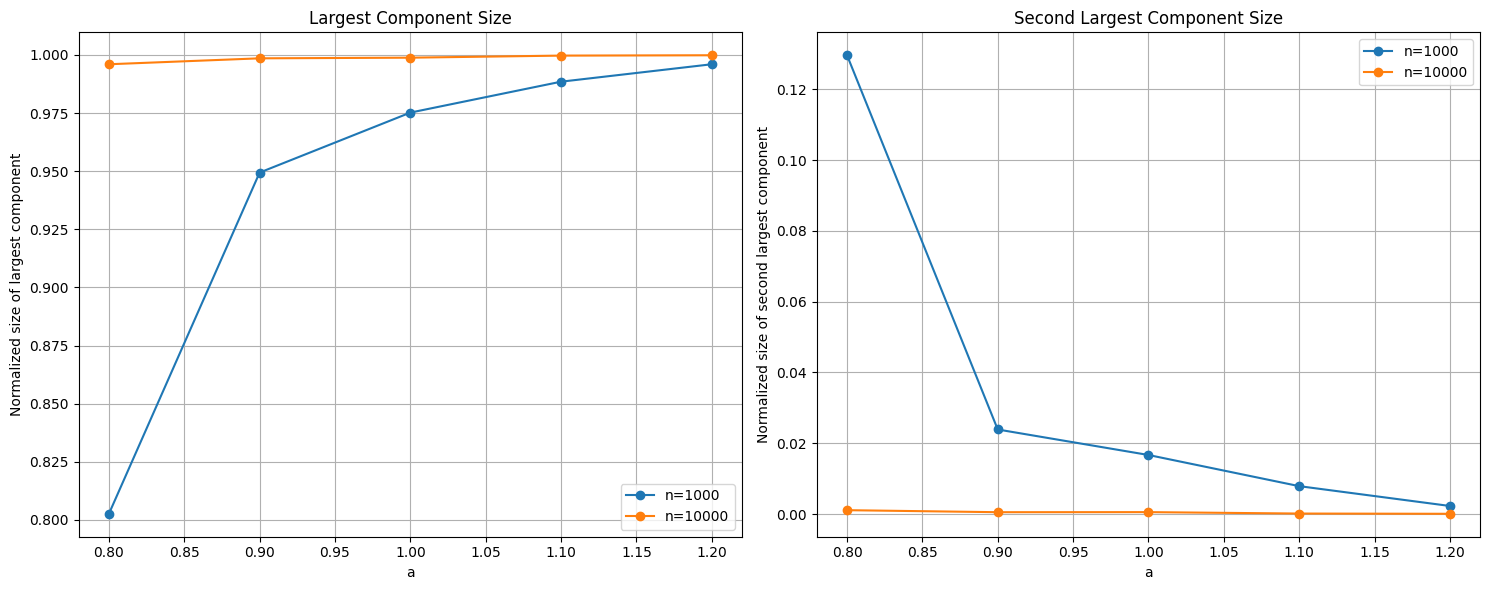

In [3]:
results = benchmark_comparison(n, r)
print(f"Speedup factor: {results['speedup']:.2f}x")

KeyboardInterrupt: 